### Programming Assignment 5.1: Random forest size

- work with a random forest – one of the most common families of algorithms
- solve regression problems with it
- select parameters of a random forest

In [4]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

In [116]:
df = pd.read_csv('abalone.csv')
df['Sex'] = df['Sex'].map(lambda x: 1 if x == 'M' else (-1 if x == 'F' else 0)) # run ONCE only :)

df.head()

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,-1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [153]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

kf = KFold(n_splits=5, random_state=1, shuffle=True)
model = RandomForestRegressor(random_state=1)

In [154]:
accs = {}

for n in range(1, 51):
    model.n_estimators = n
    accs[n] = np.mean(cross_val_score(estimator=model, X=X, y=y, cv=kf, scoring='r2'))
    print(f'n = {n}, accuracy = {accs[n]}')

k = max(accs, key=accs.get)
print(f'k = {k}, accuracy = {accs.get(k)}')

n = 1, accuracy = 0.10967482068860261
n = 2, accuracy = 0.3413000096365689
n = 3, accuracy = 0.406433829066129
n = 4, accuracy = 0.4447745857536912
n = 5, accuracy = 0.46503241426823594
n = 6, accuracy = 0.47139595825898917
n = 7, accuracy = 0.4766658451893487
n = 8, accuracy = 0.4829348394224631
n = 9, accuracy = 0.4894370162945041
n = 10, accuracy = 0.4954085552428177
n = 11, accuracy = 0.4944111155773555
n = 12, accuracy = 0.49902817866563326
n = 13, accuracy = 0.5030578549564464
n = 14, accuracy = 0.5073168234618861
n = 15, accuracy = 0.5091809969556578
n = 16, accuracy = 0.5114105314179662
n = 17, accuracy = 0.5148917747729636
n = 18, accuracy = 0.5172203573170132
n = 19, accuracy = 0.5198293095329432
n = 20, accuracy = 0.51948435033775
n = 21, accuracy = 0.520529096463528
n = 22, accuracy = 0.5208044230080824
n = 23, accuracy = 0.521742855685855
n = 24, accuracy = 0.5231059969795335
n = 25, accuracy = 0.5232486470488318
n = 26, accuracy = 0.5243076139284634
n = 27, accuracy = 0.5

## Right answer: 22 (wtf)

### Homemade accuracy calculation

In [151]:
def calc_accuracy(model, kf):
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        accuracies.append(r2_score(model.predict(X_test), y_test))

    return np.mean(accuracies)

In [152]:
accs = {}

for n in range(1, 51):
    model.n_estimators = n
    accs[n] = calc_accuracy(model, kf)
    #print(f'n = {n}, accuracy = {accs[n]}')

n = max(accs, key=accs.get)
print(f'n = {n}, accuracy = {accs.get(n)}')

n = 34, accuracy = 0.25091888462685685


### Programming Assignment 5.2: Gradient Boosting Over Decisive Trees

- work with gradient boosting and adjust its hyperparameters
- compare different ways of building compositions
- understand in which case it is better to use a random forest, and in which - gradient boosting
- use log-loss metric

Метод градиентного бустинга последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

https://thecode.media/boosting/

Обратите внимание, что, хотя в градиентного бустинге гораздо более слабые базовые алгоритмы, он выигрывает у случайного леса благодаря более **"направленной" настройке — каждый следующий алгоритм исправляет ошибки имеющейся композиции. Также он обучается быстрее случайного леса благодаря использованию неглубоких деревьев.**

В то же время, случайный лес может показать более высокое качество при неограниченных ресурсах — так, он выиграет у градиентного бустинга на наших данных, если увеличить число деревьев до нескольких сотен (проверьте сами!).

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt 
import time

In [5]:
gbm = pd.read_csv('gbm-data.csv')

In [6]:
X = gbm.iloc[:, 1:].values
y = gbm.iloc[:, :1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [7]:
def learn(learning_rate, X_train, y_train, X_test, y_test):
    model = GradientBoostingClassifier(
        n_estimators=250,
        verbose=True,
        random_state=241,
        learning_rate=learning_rate
        )
    model.fit(X_train, y_train)
    
    test_score = list(range(250))
    train_score = list(range(250))

    for i, predictions in enumerate(model.staged_decision_function(X_test)):
        predictions = [x[0] for x in predictions.tolist()] # unpack this stupid format
        predictions = [1/(1 + np.exp(-x)) for x in predictions]
        test_score[i] = log_loss(y_test, predictions)

    for i, predictions in enumerate(model.staged_decision_function(X_train)):
        predictions = [x[0] for x in predictions.tolist()] # unpack this stupid format
        predictions = [1/(1 + np.exp(-x)) for x in predictions]
        train_score[i] = log_loss(y_train, predictions)

    plt.figure()
    plt.plot(test_score, 'r', linewidth=2)
    plt.plot(train_score, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    plt.show()

    print(f'learning rate: {learning_rate}\nscore: {min(test_score)}\niteration: {np.argmin(test_score)}')
    
    return train_score, test_score

/Users/vadim/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           1.0190           19.44s
         2           0.9192           14.59s
         3           0.8272           13.52s
         4           0.7834           13.82s
         5           0.7109           13.60s
         6           0.6368           12.68s
         7           0.5797           12.10s
         8           0.5610           11.70s
         9           0.5185           11.33s
        10           0.4984           11.21s
        20           0.1999           10.02s
        30           0.1313            9.34s
        40           0.0790            8.76s
        50           0.0511            8.25s
        60           0.0352            7.74s
        70           0.0245            7.49s
        80           0.0162            7.21s
        90           0.0114            6.87s
       100           0.0077            6.36s
       200           0.0002            2.02s


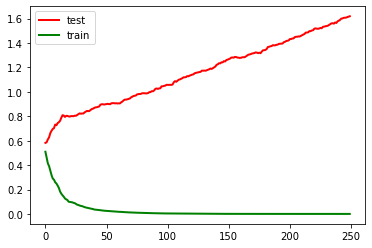

learning rate: 1
score: 0.5822942594278475
iteration: 0
*** TIME 12.205585956573486 sec; rate: 1 ***
      Iter       Train Loss   Remaining Time 
         1           1.1255           13.01s
         2           1.0035           12.33s
         3           0.9386           12.09s


/Users/vadim/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


         4           0.8844           12.30s
         5           0.8381           12.93s
         6           0.7995           12.73s
         7           0.7559           12.62s
         8           0.7205           12.67s
         9           0.6958           13.39s
        10           0.6725           13.00s
        20           0.4672           10.93s
        30           0.3179           10.64s
        40           0.2274            9.88s
        50           0.1774            9.49s
        60           0.1394            8.79s
        70           0.1050            8.29s
        80           0.0805            8.00s
        90           0.0650            7.60s
       100           0.0511            6.96s
       200           0.0058            2.07s


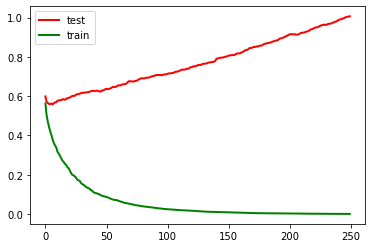

learning rate: 0.5
score: 0.5584259973942154
iteration: 6
*** TIME 12.240142822265625 sec; rate: 0.5 ***
      Iter       Train Loss   Remaining Time 
         1           1.2095           13.88s
         2           1.1006           11.37s
         3           1.0240           10.33s
         4           0.9729            9.86s
         5           0.9387            9.64s


/Users/vadim/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


         6           0.8948            9.96s
         7           0.8621            9.77s
         8           0.8360            9.66s
         9           0.8171            9.55s
        10           0.7883            9.44s
        20           0.6029            9.01s
        30           0.4760            8.46s
        40           0.3879            8.09s
        50           0.3325            7.75s
        60           0.2759            7.35s
        70           0.2304            6.95s
        80           0.1969            6.56s
        90           0.1718            6.42s
       100           0.1404            6.01s
       200           0.0358            2.12s


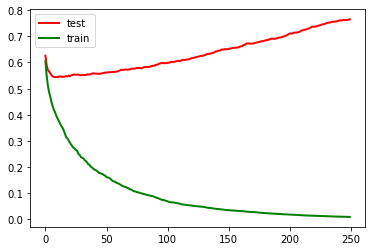

learning rate: 0.3
score: 0.5432835808866866
iteration: 10
*** TIME 12.550425052642822 sec; rate: 0.3 ***
      Iter       Train Loss   Remaining Time 
         1           1.2613           12.67s
         2           1.1715           11.50s
         3           1.1009           11.29s
         4           1.0529           11.03s


/Users/vadim/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


         5           1.0130           11.46s
         6           0.9740           11.19s
         7           0.9475           11.14s
         8           0.9197           10.87s
         9           0.8979           10.70s
        10           0.8730           10.68s
        20           0.7207            9.92s
        30           0.6055            9.34s
        40           0.5244            9.31s
        50           0.4501            8.67s
        60           0.3908            8.13s
        70           0.3372            7.60s
        80           0.3009            7.48s
        90           0.2603            7.16s
       100           0.2327            6.68s
       200           0.0835            2.21s


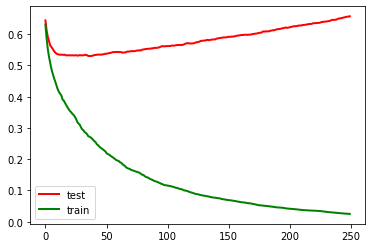

learning rate: 0.2
score: 0.5301645204906471
iteration: 36
*** TIME 12.889123916625977 sec; rate: 0.2 ***
      Iter       Train Loss   Remaining Time 
         1           1.3199           11.35s
         2           1.2645           10.12s
         3           1.2170            9.44s
         4           1.1775            9.09s
         5           1.1404            9.00s


/Users/vadim/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


         6           1.1106            9.04s
         7           1.0844            8.96s
         8           1.0617            8.82s
         9           1.0411            8.71s
        10           1.0223            8.60s
        20           0.8864            8.73s
        30           0.7844            8.81s
        40           0.7176            8.63s
        50           0.6590            8.31s
        60           0.6120            8.01s
        70           0.5599            7.61s
        80           0.5242            7.23s
        90           0.4829            6.72s
       100           0.4473            6.33s
       200           0.2379            2.09s


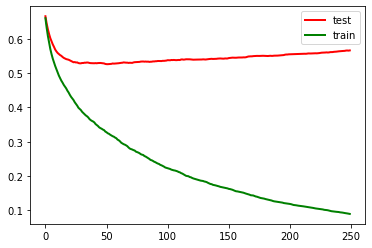

learning rate: 0.1
score: 0.5259049090698129
iteration: 51
*** TIME 12.517916917800903 sec; rate: 0.1 ***


In [10]:
learning_rates = [1, 0.5, 0.3, 0.2, 0.1]

for lr in learning_rates:
    start = time.time()
    learn(lr, X_train, y_train, X_test, y_test)
    print(f'*** TIME {time.time() - start} sec; rate: {lr} ***')

- learning rate: 0.2
- score: 0.5301645204906471
- iteration: 36

In [260]:
forest = RandomForestClassifier(n_estimators=36, random_state=241)
forest.fit(X_train, y_train)

log_loss(y_test, forest.predict_proba(X_test))

<ipython-input-260-07e584b1d4a7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


0.5415685811957381